In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#database connection settings
import psycopg2

db_name = "traviato_development"
db_host = "localhost"
db_port = "5432"
db_user = "lievgarcia"
db_pwd = "traviato81"

conn = psycopg2.connect(database=db_name, user=db_user, password=db_pwd, host=db_host, port=db_port)

In [3]:
######################## libraries ########################

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.ticker as ticker
import numpy as np

import sys
sys.path.append('../../')

from utils.utility_functions import label_top
from utils.utility_functions import get_last_name
from utils.utility_functions import make_dash_zero
from utils.utility_functions import make_dash_zero_float

# from utils.utility_functions import shorten_opera_name

##################### CHARTING OPTIONS #####################

# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Palatino']})

rc('text', usetex=False)
# rc.rcParams['text.usetex']=True
# rc.rcParams['text.latex.unicode']=True

from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

colors = ['#8a170f', '#8a540f', '#828a0f', '#458a0f', '#0f8a17', '#0f8a54', '#0f828a', '#0f458a', '#170f8a', '#540f8a', '#8a0f82', '#8a0f45', '#8a170f']


##################### SOURCES OPTIONS #####################

archival_sources = ['Metropolitan Opera', 'Opera Scotland', 'Royal Opera House', 'Teatro alla Scala', 'Wiener Staatsoper', 
                    'Chicago Lyric Opera','San Francisco Opera','Czech National Theatre','Glyndebourne','Salzburg Festival',
                    'Sweden Opera House','National Opera de Paris','Opera Comique']
commercial_sources_world = ['bachtrack.com','operabase.com','operacritic.com']
commercial_sources_uk = ['Concert-Diary','U.K. Theatre Web']
government_sources = ['National Central Opera Service Reports', 'Opera America']

##############################################################################

In [4]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 'date_end', 'premiere_date', 'performance_count']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

In [139]:
#################### top composers share of repertoire ####################

sources = archival_sources
# print(sources)
num_sources = len(sources)

o_df = mdf.copy()
# o_df = o_df[o_df['source_name']=='National Opera de Paris']
o_df = o_df[o_df['source_name'].isin(sources)]
o_df = o_df[o_df['source_name']!='Opera Comique']

o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['composer'] != '']
o_df = o_df[o_df['year'] < 2011]
o_df = o_df[o_df['year'] >= 1972]

o_df['three_year'] = o_df.apply(lambda row: 1972 + 3*int((row['year']-1972)/3), axis=1)
# o_df

o_df = o_df[['source_name', 'year', 'work']]
o_df = o_df.drop_duplicates()

ci_df = o_df.groupby(['year', 'work']).agg({'source_name': 'count' })
ci_df = ci_df.rename({'source_name': 'ci'}, axis='columns')

w_df = mdf.copy()
w_df = w_df[w_df['source_name'].isin(sources)]
w_df = w_df[w_df['source_name']!='Opera Comique']
# w_df = w_df[w_df['source_name']=='Royal Opera House']

w_df = w_df.groupby(['source_name', 'work', 'year']).agg({'performance_count': np.sum })
w_df['perc'] = w_df.groupby(level = ['source_name', 'year']).transform(lambda x: x/x.sum())

w_df = w_df.reset_index(level=['source_name', 'year', 'work'])
w_df = w_df.sort_values(by=['source_name', 'year'])

w_df = w_df.drop(columns=['performance_count'])
w_df = w_df.set_index(['year', 'work'])

# w_df

df = w_df.join(ci_df, how='inner')
df['amended_ci'] = df['perc']*df['ci']
df = df.round(2)
df = df.reset_index(level=['year', 'work'])
df = df[['source_name','year','amended_ci']].groupby(['source_name', 'year']).agg(['sum', 'mean', 'count'])
df = df.xs('amended_ci', axis=1, drop_level=True)

df = df.round(2)
# df['c'] = df.apply(lambda x: '{} ({})'.format(x['sum'],int(x['count'])),axis=1)
# df


df = df.reset_index(level=['source_name', 'year'])
df = df.pivot(index='year', columns='source_name', values=['sum'])
df = df.fillna(value=0)
df = df.round(2)

decades = d_df.columns.get_values().tolist()
decades = [str(d) for d in decades]

print('r'*len(decades))
print('\\textbf{Decade} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero_float(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

# ###############################################################

rrrrrrrrrrrr
\textbf{Decade} & \textbf{('performance_count', 'Chicago Lyric Opera') & \textbf{('performance_count', 'Czech National Theatre') & \textbf{('performance_count', 'Glyndebourne') & \textbf{('performance_count', 'Metropolitan Opera') & \textbf{('performance_count', 'National Opera de Paris') & \textbf{('performance_count', 'Opera Scotland') & \textbf{('performance_count', 'Royal Opera House') & \textbf{('performance_count', 'Salzburg Festival') & \textbf{('performance_count', 'San Francisco Opera') & \textbf{('performance_count', 'Sweden Opera House') & \textbf{('performance_count', 'Teatro alla Scala') & \textbf{('performance_count', 'Wiener Staatsoper') \\ \midrule 
1972 & 5.15 & 2.8 & 3.62 & 3.52 & 2.3 & 3.71 & 3.55 & 4.74 & 3.89 & 3.64 & 2.53 & 3.38 \\
1973 & 4.88 & 2.19 & 4.21 & 3.77 & 5.17 & 3.13 & 3.95 & 3.19 & 3.56 & 3.21 & 1.63 & 3.75 \\
1974 & 3.05 & 2.42 & 3.87 & 3.43 & 3.59 & 2.85 & 4.31 & 3.58 & 2.9 & 3.18 & 2.99 & 3.47 \\
1975 & 3.63 & 2.2 & 4.08 & 3.3 & 3.41 & 

In [297]:
import pandas as pd

columns=['source_id', 'source_name', 'composer', 'work', 'country', 'state', 'city', 'theatre', 'date_start', 
         'date_end', 'premiere_date', 'performance_count', 'composer_dob', 'theatre_category']

cursor = conn.cursor()  
query = "SELECT s.id as source_id, " + \
        "       s.name as source_name, " + \
        "       coalesce(c.name, l.composer) as composer, " + \
        "       coalesce(w.name, l.work) as work, " + \
        "       l.country, " + \
        "       l.state, " + \
        "       l.city, " + \
        "       l.theatre, " + \
        "       l.date_start, " + \
        "       l.date_end, " + \
        "       w.premiere_date, " + \
        "       l.performance_count, " + \
        "       c.date_of_birth, " + \
        "       CASE WHEN l.source_id = 1 then 'Professional' when opera_america_name IS NULL THEN 'Amateur' ELSE 'Professional' END as theatre_category " + \
        "from sources s " + \
        "INNER JOIN listings l on s.id = l.source_id " + \
        "LEFT JOIN theatre_mapping tm ON l.theatre = tm.name " + \
        "LEFT JOIN listing_mappers lm ON l.map_key = lm.map_key " + \
        "LEFT JOIN works w ON lm.work_uri = w.uri " + \
        "LEFT JOIN composers c ON w.composer_id = c.id " + \
        "WHERE source_id = 1 AND w.uri != 'W1' " + \
        "ORDER BY s.id, l.country, l.state, l.city"
        
cursor.execute(query)

mdf = pd.DataFrame(cursor.fetchall(), columns=columns)
mdf['year'] = mdf.apply(lambda row: row['date_start'].year, axis=1)
mdf['decade'] = mdf.apply(lambda row: 10*int(row['year']/10), axis=1)
mdf[['premiere_date']] = mdf[['premiere_date']].fillna(value=0)
mdf['work_decade'] = mdf.apply(lambda row: 10*int(row['premiere_date']/10), axis=1)

mdf.loc[mdf['theatre']=='New York City Opera', 'theatre_category'] = 'Professional'

In [333]:
o_df = mdf.copy()
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['year'] < 2019]
o_df = o_df[o_df['year'] > 1991]
o_df = o_df[o_df['theatre_category']=='Professional']
# o_df = o_df[o_df['country']=='United States']

top_df = o_df.groupby(['theatre']).agg({'performance_count': np.sum })
top_df = top_df.reset_index(level=['theatre'])
# top_df = top_df.nlargest(60, 'performance_count')
top_25 = top_df.nlargest(10, 'performance_count')

top_92 = ['Metropolitan Opera', 'Lyric Opera of Chicago', 'San Francisco Opera', 'Skylight Music Theatre', 
          'Houston Grand Opera', 'Los Angeles Opera', 'Seattle Opera', 'Santa Fe Opera', 'Central City Opera', 
          'Virginia Opera', 'Opera Theatre of Saint Louis', 'Sarasota Opera']

top_df = top_df['theatre'].values.tolist()
top_25 = top_25['theatre'].values.tolist()

o_df = o_df[o_df['theatre'].isin(top_92)]

o_df['three_year'] = o_df.apply(lambda row: 1972 + 3*int((row['year']-1972)/3), axis=1)

ci_df = o_df.copy()
ci_df = ci_df[['theatre', 'year', 'work']]
ci_df = ci_df.drop_duplicates()
ci_df = ci_df.groupby(['year', 'work']).agg({'theatre': 'count' })
ci_df = ci_df.rename({'theatre': 'ci'}, axis='columns')

# ci_df = ci_df.reset_index(level=['year', 'work'])
# ci_df = ci_df.sort_values(by='ci', ascending=False)
ci_df

w_df = o_df.copy()
# w_df = w_df[w_df['source_name']=='Royal Opera House']

w_df = w_df.groupby(['theatre', 'work', 'year']).agg({'performance_count': np.sum })
w_df['perc'] = w_df.groupby(level = ['theatre', 'year']).transform(lambda x: x/x.sum())

w_df = w_df.reset_index(level=['theatre', 'year', 'work'])
w_df = w_df.sort_values(by=['theatre', 'year'])

w_df = w_df.drop(columns=['performance_count'])
w_df = w_df.set_index(['year', 'work'])

w_df

df = w_df.join(ci_df, how='inner')
df['amended_ci'] = df['perc']*df['ci']
df = df.round(2)
df = df.reset_index(level=['year', 'work'])
# df = df[['theatre','year','ci']].groupby(['theatre', 'year']).agg(['sum', 'mean', 'count'])
# df = df.xs('ci', axis=1, drop_level=True)
df = df[['theatre','year','amended_ci']].groupby(['theatre', 'year']).agg(['sum', 'mean', 'count'])
df = df.xs('amended_ci', axis=1, drop_level=True)

df = df.reset_index(level=['theatre', 'year'])
df1 = df.copy()

df = df.pivot(index='theatre', columns='year', values=['sum'])
# df = df.fillna(value=0)
df = df.round(2)

df

decades = df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]
print('r'*len(decades))
print('\\textbf{Company} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero_float(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")

# ###############################################################

rrrrrrrrrrrrrrrrrrrrrrrrrrr
\textbf{Company} & \textbf{1992 & \textbf{1993 & \textbf{1994 & \textbf{1995 & \textbf{1996 & \textbf{1997 & \textbf{1998 & \textbf{1999 & \textbf{2000 & \textbf{2001 & \textbf{2002 & \textbf{2003 & \textbf{2004 & \textbf{2005 & \textbf{2006 & \textbf{2007 & \textbf{2008 & \textbf{2009 & \textbf{2010 & \textbf{2011 & \textbf{2012 & \textbf{2013 & \textbf{2014 & \textbf{2015 & \textbf{2016 & \textbf{2017 & \textbf{2018 \\ \midrule 
Central City Opera & 1.57 & 1.0 & 1.35 & 1.64 & 1.34 & 2.86 & 1.37 & 1.74 & 1.68 & 1.7 & 2.09 & 1.26 & 1.4 & 1.37 & 2.24 & 2.0 & 1.0 & 1.42 & 2.14 & 2.31 & 2.13 & 1.44 & 1.66 & 1.0 & 1.0 & 2.3 & 2.0 \\
Houston Grand Opera & 1.24 & 1.42 & 1.57 & 1.85 & 2.26 & 1.62 & 2.46 & 2.03 & 1.84 & 1.43 & 1.61 & 1.65 & 2.13 & 1.96 & 2.63 & 1.53 & 2.11 & 2.43 & 1.87 & 2.01 & 2.36 & 1.75 & 1.43 & 1.0 & 1.01 & 2.19 & 1.82 \\
Los Angeles Opera & 1.73 & 2.39 & 1.9 & 2.06 & 2.26 & 1.88 & 2.22 & 2.0 & 1.57 & 2.27 & 1.6 & 1.64 & 2.0 & 2.5 & 2.99 & 1.93

In [387]:
def contemporary(composer, composer_dob):
    if composer_dob > 1881:
        category = 'yes'
    elif composer in ['Leoš Janáček', 'Arnold Schoenberg']:
        category = 'yes'
    else:
        category = 'no'
    return category

o_df = mdf.copy()
o_df = o_df[o_df['work'] != 'Unknown']
o_df = o_df[o_df['year'] < 2019]
o_df = o_df[o_df['year'] > 1991]
o_df = o_df[o_df['theatre_category']=='Professional']

top_92 = ['Metropolitan Opera', 'Lyric Opera of Chicago', 'San Francisco Opera', 'Skylight Music Theatre', 
          'Houston Grand Opera', 'Los Angeles Opera', 'Seattle Opera', 'Santa Fe Opera', 'Central City Opera', 
          'Virginia Opera', 'Opera Theatre of Saint Louis', 'Sarasota Opera']

o_df = o_df[o_df['theatre'].isin(top_92)]

ci_df = o_df.copy()
ci_df['contemporary'] = ci_df.apply(lambda x: contemporary(x['composer'], x['composer_dob']), axis=1)

ci_df = ci_df.groupby(['theatre', 'year', 'contemporary']).agg({'performance_count': np.sum })
ci_df['perc_contemporary'] = ci_df.groupby(level = ['theatre', 'year']).transform(lambda x: x/x.sum())

ci_df = ci_df.reset_index(level=['theatre', 'year', 'contemporary'])
ci_df = ci_df[ci_df['contemporary']=='yes']
ci_df = ci_df.pivot(index='theatre', columns='year', values=['perc_contemporary'])
ci_df = 100*ci_df
ci_df = ci_df.fillna(value=0)
ci_df = ci_df.round(0)
ci_df

decades = ci_df.columns.get_level_values(1).get_values().tolist()
decades = [str(d) for d in decades]
print('r'*len(decades))
print('\\textbf{Company} & \\textbf{' + ' & \\textbf{'.join(decades) + ' \\\ \midrule ')

for idx,row in ci_df.iterrows():
    values = row.values.tolist()
    values = [make_dash_zero(c) for c in values ]
    print(str(row.name) + ' & ' + ' & '.join(values) + " \\\\")
    

###############################################################

rrrrrrrrrrrrrrrrrrrrrrrrrrr
\textbf{Company} & \textbf{1992 & \textbf{1993 & \textbf{1994 & \textbf{1995 & \textbf{1996 & \textbf{1997 & \textbf{1998 & \textbf{1999 & \textbf{2000 & \textbf{2001 & \textbf{2002 & \textbf{2003 & \textbf{2004 & \textbf{2005 & \textbf{2006 & \textbf{2007 & \textbf{2008 & \textbf{2009 & \textbf{2010 & \textbf{2011 & \textbf{2012 & \textbf{2013 & \textbf{2014 & \textbf{2015 & \textbf{2016 & \textbf{2017 & \textbf{2018 \\ \midrule 
Central City Opera & 33 & 25 & - & 36 & 67 & 26 & 29 & 29 & 66 & 65 & 63 & 20 & 30 & 62 & 28 & 38 & 50 & 33 & 29 & 28 & 62 & 56 & 55 & 100 & 57 & 10 & 16 \\
Houston Grand Opera & 54 & 30 & 30 & 32 & 41 & 5 & 17 & 28 & 38 & - & 26 & 20 & 46 & 16 & 24 & 15 & 27 & 26 & 29 & 23 & 6 & - & 51 & 25 & 55 & 16 & 17 \\
Los Angeles Opera & 38 & 4 & - & 22 & - & 27 & 14 & - & 21 & 2 & 11 & 10 & 26 & - & 11 & 41 & 12 & 7 & 13 & 24 & 16 & 9 & 17 & 46 & 62 & 13 & 33 \\
Lyric Opera of Chicago & 15 & 13 & 35 & 17 & 20 & 23 & 22 & 12 & 19 & 23 & 21 

In [338]:
ddf = df.join(ci_df)
ddf

sum                                            \
year                          1992  1993  1994  1995  1996  1997  1998  1999   
theatre                                                                        
Central City Opera            1.57  1.00  1.35  1.64  1.34  2.86  1.37  1.74   
Houston Grand Opera           1.24  1.42  1.57  1.85  2.26  1.62  2.46  2.03   
Los Angeles Opera             1.73  2.39  1.90  2.06  2.26  1.88  2.22  2.00   
Lyric Opera of Chicago        1.63  2.04  1.51  1.72  1.69  2.12  1.75  1.47   
Metropolitan Opera            1.81  2.13  1.84  1.73  1.97  1.79  1.98  1.49   
Opera Theatre of Saint Louis  1.90  0.99  1.00  1.27  1.87  3.34  1.67  2.11   
San Francisco Opera           2.04  1.87  1.50  1.97  1.87  2.37  1.49  1.50   
Santa Fe Opera                1.27  2.50  1.78  1.50  1.94  1.57  2.61  1.51   
Sarasota Opera                2.39  1.58  2.26  1.00  2.01  1.96  2.21  1.33   
Seattle Opera                 1.84  1.74  1.20  2.46  1.63  1.65  2.22  1.84   
Skylight Music Theatre        1.27  1.32  1.00  1.60  1.33  1.61  1.00  1.00   
Virginia Opera                1.30  1.95  2.01  2.00  1.84  2.64  1.54  1.78   

                                            ...    perc_contemporary  \
year                          2000  2001    ...                 2009   
theatre                                     ...                        
Central City Opera            1.68  1.70    ...             0.333333   
Houston Grand Opera           1.84  1.43    ...             0.260870   
Los Angeles Opera             1.57  2.27    ...             0.066667   
Lyric Opera of Chicago        2.06  1.82    ...             0.080460   
Metropolitan Opera            1.83  1.64    ...             0.030973   
Opera Theatre of Saint Louis  1.57  1.84    ...             0.222222   
San Francisco Opera           1.68  2.33    ...             0.086420   
Santa Fe Opera                1.67  2.20    ...                  NaN   
Sarasota Opera                1.97  2.11    ...                  NaN   
Seattle Opera                 1.67  2.28    ...             0.147059   
Skylight Music Theatre        1.00  1.61    ...             0.142857   
Virginia Opera                1.63  2.58    ...                  NaN   

                                                                      \
year                              2010      2011      2012      2013   
theatre                                                                
Central City Opera            0.294118  0.279070  0.625000  0.560000   
Houston Grand Opera           0.290323  0.227273  0.058824       NaN   
Los Angeles Opera             0.127660  0.240000  0.160000  0.085714   
Lyric Opera of Chicago        0.098592       NaN  0.029412  0.015385   
Metropolitan Opera            0.046392  0.060976  0.067568  0.085000   
Opera Theatre of Saint Louis  0.428571  0.250000  0.500000  0.354839   
San Francisco Opera           0.078947  0.111111  0.223881  0.142857   
Santa Fe Opera                0.162162  0.297297  0.032258       NaN   
Sarasota Opera                     NaN  0.157895  0.111111  0.235294   
Seattle Opera                 0.166667  0.190476       NaN       NaN   
Skylight Music Theatre        0.071429  0.500000  1.000000       NaN   
Virginia Opera                0.266667       NaN       NaN  0.413793   

                                                                                
year                              2014      2015      2016      2017      2018  
theatre                                                                         
Central City Opera            0.551724  1.000000  0.571429  0.100000  0.161290  
Houston Grand Opera           0.509434  0.250000  0.545455  0.156250  0.166667  
Los Angeles Opera             0.166667  0.457143  0.625000  0.127273  0.333333  
Lyric Opera of Chicago        0.290698  0.460674  0.071429  0.200000  0.266667  
Metropolitan Opera            0.079832  0.025424  0.181818  0.037037  0.030043  
Opera Theatre of Sai

In [365]:
for year in range(1992, 2018):    
    sub_df = ddf.iloc[:, ddf.columns.get_level_values(1)==year]
    sub_df = sub_df.swaplevel(0,1,axis =1)
    sub_df = sub_df.xs(year, axis=1, drop_level=True)
    sub_df = sub_df[~sub_df['sum'].isna()]
    sub_df = sub_df.fillna(value=0)    
    if year==1992:
        fdf = sub_df.copy()
    else:
        fdf = pd.concat([fdf, sub_df])

fdf

,sum,perc_contemporary
theatre,,
Central City Opera,1.57,0.333333
Houston Grand Opera,1.24,0.540000
Los Angeles Opera,1.73,0.377049
Lyric Opera of Chicago,1.63,0.151261
Metropolitan Opera,1.81,0.095057
Opera Theatre of Saint Louis,1.90,0.473684
San Francisco Opera,2.04,0.169643
Santa Fe Opera,1.27,0.000000
Sarasota Opera,2.39,0.000000


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


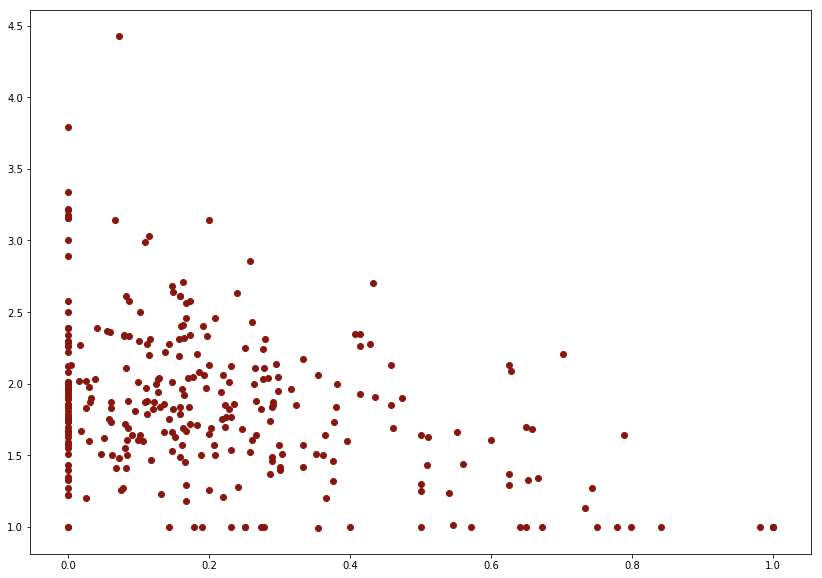

In [366]:
y = fdf['sum'].tolist()
z = fdf['perc_contemporary'].tolist()
n = fdf.index.values

fig, ax = plt.subplots(figsize=(14, 10))
ax.scatter(z, y, color=colors[0])

In [398]:
fdf[fdf['perc_contemporary']>=.8].sort_values(by='perc_contemporary').corr()

,sum,perc_contemporary
sum,NaN,NaN
perc_contemporary,NaN,1.0


In [399]:
fdf[fdf['perc_contemporary']>=.8]

,sum,perc_contemporary
theatre,,
Skylight Music Theatre,1.0,0.840580
Skylight Music Theatre,1.0,0.981818
Skylight Music Theatre,1.0,1.000000
Central City Opera,1.0,1.000000
Skylight Music Theatre,1.0,1.000000
